In [6]:
#no log2 tranformation code

import pandas as pd
import numpy as np

# Load dataset with proper handling of mixed data types
file_path = "/content/GSE228582_Fibroblast_RNA_Seq_raw_counts.csv"
df = pd.read_csv(file_path, low_memory=False)  # Prevents DtypeWarning

# Ensure dataset has enough columns
if df.shape[1] < 2:
    raise ValueError("The dataset must contain at least two columns: Gene_ID and Gene_Name.")

# Rename columns for clarity
df.rename(columns={df.columns[0]: "Gene_ID", df.columns[1]: "Gene_Name"}, inplace=True)

# Identify expression columns
expression_cols = df.columns[2:]

# Convert expression columns to numeric, coercing errors to NaN
df[expression_cols] = df[expression_cols].apply(pd.to_numeric, errors='coerce')

# Fill missing values with 0 (assuming missing values imply no expression)
df.fillna(0, inplace=True)

# Drop duplicate genes, keeping the one with the highest total expression
df["Total_Expression"] = df[expression_cols].sum(axis=1)  # Compute total expression for sorting
df = df.sort_values(by=["Gene_ID", "Total_Expression"], ascending=[True, False])  # Sort by Gene_ID, then by expression
df = df.drop_duplicates(subset="Gene_ID", keep="first")  # Keep only the highest expression per Gene_ID
df.drop(columns=["Total_Expression"], inplace=True)  # Remove the temporary column

# Save the preprocessed data
output_path = "/content/GSE228582_Fibroblast_RNA_Seq_raw_counts.csv"
df.to_csv(output_path, index=False)

print(f"Preprocessed data saved at: {output_path}")


Preprocessed data saved at: /content/GSE228582_Fibroblast_RNA_Seq_raw_counts.csv


In [7]:
%pip install pydeseq2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 7.4 MB/s eta 0:00:00


In [8]:
#this imports the DeseqDataSet class from the pydeseq2.dds module.
#pydeseq2 is a Python implementation of the DESeq2 method, commonly used for differential gene expression analysis from RNA-seq count data.
#DeseqDataSet is used to create a dataset suitable for DESeq2 analysis.

from pydeseq2.dds import DeseqDataSet
import pandas as pd

In [10]:
#reads and display the csv file

counts=pd.read_csv("/content/GSE228582_Fibroblast_RNA_Seq_raw_counts.csv")
counts

,Gene_ID,Gene_Name,2525-normal breast fibroblast,8727-normal adjacent breast fibroblast,4009- normal breast fibroblast,30413-DCIS fibroblast,70213-DCIS fibroblast,80H- DCIS fibroblast,21714-DCIS fibroblast,1213249-DCIS fibroblast,102115- DCIS fibroblast,2760- IDC fibroblast,8727- IDC fibroblast,2300- IDC fibroblast,8870- IDC fibroblast,9019- IDC fibroblast,8661- IDC fibroblast
0,0,32135.564190,32927.997990,27333.100400,43807.978780,35953.015470,37913.887250,21032.575670,20301.863380,32058.655320,23926.929520,33208.699430,40771.559390,29585.858930,28708.389690,24988.094880,24941.775790
1,42796,20.505090,19.419049,19.705419,20.650942,19.893176,19.994607,12.095198,22.277871,13.530673,24.618104,13.434793,16.575087,20.157209,22.222092,21.225607,13.129636
2,42797,6.912624,3.553181,9.216195,2.348778,6.215213,6.517229,5.800614,14.962573,2.972055,7.859744,1.369682,6.343552,5.202899,1.451953,6.952915,4.397386
3,42798,51.940829,129.149021,52.777637,107.881090,103.792926,97.391452,75.153944,68.303788,68.580734,70.517332,85.575342,59.206484,50.655850,95.478796,87.365647,116.311904
4,42799,29.968198,31.849817,30.844418,26.934685,27.322209,29.485718,31.642280,32.225255,33.664671,34.702503,32.169659,32.263441,33.180547,32.457848,33.087490,32.167609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10664,ZXDC,20.039525,20.503252,25.354483,17.854778,22.590556,20.184429,22.652034,20.084467,21.832316,22.613817,23.463246,23.310848,20.564859,26.526464,20.841275,20.142529
10665,ZYG11B,24.249849,30.175206,28.775747,23.772478,22.972684,22.373712,28.791370,26.866236,31.150715,31.103180,29.859065,27.164726,32.998177,29.440668,28.021295,24.602437
10666,ZYX,439.270433,590.257507,399.863531,401.763007,490.799490,517.505981,504.879255,417.280301,605.092579,511.680897,649.610340,364.975913,417.841029,677.804713,557.351250,617.374247
10667,ZZEF1,32.660377,34.919937,32.488746,24.423221,31.772886,28.435368,31.204764,33.932554,42.636703,45.857253,42.841267,30.796921,34.264037,34.949853,36.354311,23.935535


In [11]:
#This sets the "Gene_ID" column as the index of the counts DataFrame.
#After this operation, each row will be identified by its corresponding gene ID rather than a default numeric index.
#This is useful because gene expression data is typically structured with genes as row indices and samples as column names.

counts=counts.set_index("Gene_ID")
counts

,Gene_Name,2525-normal breast fibroblast,8727-normal adjacent breast fibroblast,4009- normal breast fibroblast,30413-DCIS fibroblast,70213-DCIS fibroblast,80H- DCIS fibroblast,21714-DCIS fibroblast,1213249-DCIS fibroblast,102115- DCIS fibroblast,2760- IDC fibroblast,8727- IDC fibroblast,2300- IDC fibroblast,8870- IDC fibroblast,9019- IDC fibroblast,8661- IDC fibroblast
Gene_ID,,,,,,,,,,,,,,,,
0,32135.564190,32927.997990,27333.100400,43807.978780,35953.015470,37913.887250,21032.575670,20301.863380,32058.655320,23926.929520,33208.699430,40771.559390,29585.858930,28708.389690,24988.094880,24941.775790
42796,20.505090,19.419049,19.705419,20.650942,19.893176,19.994607,12.095198,22.277871,13.530673,24.618104,13.434793,16.575087,20.157209,22.222092,21.225607,13.129636
42797,6.912624,3.553181,9.216195,2.348778,6.215213,6.517229,5.800614,14.962573,2.972055,7.859744,1.369682,6.343552,5.202899,1.451953,6.952915,4.397386
42798,51.940829,129.149021,52.777637,107.881090,103.792926,97.391452,75.153944,68.303788,68.580734,70.517332,85.575342,59.206484,50.655850,95.478796,87.365647,116.311904
42799,29.968198,31.849817,30.844418,26.934685,27.322209,29.485718,31.642280,32.225255,33.664671,34.702503,32.169659,32.263441,33.180547,32.457848,33.087490,32.167609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,20.039525,20.503252,25.354483,17.854778,22.590556,20.184429,22.652034,20.084467,21.832316,22.613817,23.463246,23.310848,20.564859,26.526464,20.841275,20.142529
ZYG11B,24.249849,30.175206,28.775747,23.772478,22.972684,22.373712,28.791370,26.866236,31.150715,31.103180,29.859065,27.164726,32.998177,29.440668,28.021295,24.602437
ZYX,439.270433,590.257507,399.863531,401.763007,490.799490,517.505981,504.879255,417.280301,605.092579,511.680897,649.610340,364.975913,417.841029,677.804713,557.351250,617.374247


In [16]:
#shows datatype of counts

counts.dtypes

,0
Gene_ID,
0,float64
42796,float64
42797,float64
42798,float64
42799,float64
...,...
ZXDC,float64
ZYG11B,float64
ZYX,float64


In [19]:
import pandas as pd

# Assuming 'counts' is your DataFrame where sample names are the index
# You can extract the sample names like this (skip the first two rows if needed)
sample_names = [
    "2525-normal breast fibroblast",
    "8727-normal adjacent breast fibroblast",
    "4009- normal breast fibroblast",
    "30413-DCIS fibroblast",
    "70213-DCIS fibroblast",
    "80H- DCIS fibroblast",
    "21714-DCIS fibroblast",
    "1213249-DCIS fibroblast",
    "102115- DCIS fibroblast",
    "2760- IDC fibroblast",
    "8727- IDC fibroblast",
    "2300- IDC fibroblast",
    "8870- IDC fibroblast",
    "9019- IDC fibroblast",
    "8661- IDC fibroblast"
]

# Define conditions based on sample names
conditions = []
for name in sample_names:
    name_lower = name.lower()
    if "normal" in name_lower:
        conditions.append("Normal")
    elif "dcis" in name_lower:
        conditions.append("DCIS")
    elif "idc" in name_lower:
        conditions.append("IDC")
    else:
        conditions.append("Unknown")

# Create metadata DataFrame
metadata = pd.DataFrame(zip(sample_names, conditions), columns=["Sample", "Condition"])
print(metadata)

                                    Sample Condition
0            2525-normal breast fibroblast    Normal
1   8727-normal adjacent breast fibroblast    Normal
2           4009- normal breast fibroblast    Normal
3                    30413-DCIS fibroblast      DCIS
4                    70213-DCIS fibroblast      DCIS
5                     80H- DCIS fibroblast      DCIS
6                    21714-DCIS fibroblast      DCIS
7                  1213249-DCIS fibroblast      DCIS
8                  102115- DCIS fibroblast      DCIS
9                     2760- IDC fibroblast       IDC
10                    8727- IDC fibroblast       IDC
11                    2300- IDC fibroblast       IDC
12                    8870- IDC fibroblast       IDC
13                    9019- IDC fibroblast       IDC
14                    8661- IDC fibroblast       IDC


In [20]:
#This sets the "Sample" column as the index of the metadata DataFrame.

metadata=metadata.set_index('Sample')
metadata

,Condition
Sample,
2525-normal breast fibroblast,Normal
8727-normal adjacent breast fibroblast,Normal
4009- normal breast fibroblast,Normal
30413-DCIS fibroblast,DCIS
70213-DCIS fibroblast,DCIS
80H- DCIS fibroblast,DCIS
21714-DCIS fibroblast,DCIS
1213249-DCIS fibroblast,DCIS
102115- DCIS fibroblast,DCIS


In [21]:
#shows datatype of counts

counts.dtypes

,0
Gene_ID,
0,float64
42796,float64
42797,float64
42798,float64
42799,float64
...,...
ZXDC,float64
ZYG11B,float64
ZYX,float64


In [23]:
# Convert counts to integers (rounding if needed)
counts = counts.round().astype(int)

In [25]:

dds = DeseqDataSet(counts=counts,
                   metadata=metadata,
                   design="~ Condition")


ValueError: Observations annot. `obs` must have as many rows as `X` has rows (16), but has 15 rows.

In [26]:
# Ensure no NaNs or negatives, round floats to nearest int
counts = counts.fillna(0).round().astype(int)


In [27]:
print(counts.dtypes.value_counts())
print((counts % 1 != 0).any().any())  # Should be False


int64    10669
Name: count, dtype: int64
False


In [28]:
# Recreate metadata (if needed)
metadata = pd.DataFrame({
    'Condition': ['normal']*4 + ['DCIS']*6 + ['IDC']*6
}, index=counts.index)

print(metadata.head())
print(metadata['Condition'].value_counts())


                                       Condition
Gene_Name                                 normal
2525-normal breast fibroblast             normal
8727-normal adjacent breast fibroblast    normal
4009- normal breast fibroblast            normal
30413-DCIS fibroblast                       DCIS
Condition
DCIS      6
IDC       6
normal    4
Name: count, dtype: int64


In [29]:
pip install pydeseq2


In [30]:
from pydeseq2.dds import DeseqDataSet


In [31]:
dds = DeseqDataSet(counts=counts,
                   metadata=metadata,
                   design="~ Condition")


In [32]:
#This performs DESeq2 normalization and statistical testing on the dataset (dds).
#The method applies size factor normalization, dispersion estimation, and Wald significance testing to identify differentially expressed genes (DEGs).
dds.deseq2()


Fitting size factors...
... done in 0.03 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 10.17 seconds.

Fitting dispersion trend curve...
... done in 0.26 seconds.

Fitting MAP dispersions...
... done in 20.05 seconds.

Fitting LFCs...
... done in 6.22 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 0 outlier genes.



In [33]:
dds

AnnData object with n_obs × n_vars = 16 × 10669
    obs: 'Condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks'

In [34]:
# Imports the DeseqStats class from the pydeseq2.ds module.
#DeseqStats is used to compute statistical results after running deseq2() on a DeseqDataSet (dds).
#It helps extract log fold changes (LFC), p-values, and adjusted p-values for differential expression analysis.

from pydeseq2.ds import DeseqStats

In [40]:
#This creates a DeseqStats object for differential expression analysis between the Control and Dilated groups.
#dds → The DeseqDataSet object containing gene expression count data and sample metadata.
#This runs statistical analysis on the dataset

stat_res_cd = DeseqStats(dds, contrast=('Condition', 'IDC', 'DCIS'))
stat_res_cd.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: Condition IDC vs DCIS
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Gene_ID                                                                      
0        30998.018086        0.186088  0.225786  0.824176  0.409839  0.999672
42796       18.805290        0.017108  0.241147  0.070944  0.943443  0.999672
42797        5.634905       -0.786525  0.523652 -1.501999  0.133097  0.776622
42798       83.371334        0.131137  0.287003  0.456918  0.647730  0.999672
42799       31.419003        0.151397  0.167939  0.901500  0.367322  0.999672
...               ...             ...       ...       ...       ...       ...
ZXDC        21.942341        0.155404  0.205567  0.755975  0.449664  0.999672
ZYG11B      27.569145        0.190768  0.180888  1.054618  0.291600  0.966131
ZYX        509.676813        0.217714  0.163373  1.332620  0.182656  0.854753
ZZEF1       33.524517        0.036059  0.171868  0.209804  0.833820  0.999672
ZZZ3

... done in 6.90 seconds.



In [41]:
#stat_res_cd → The DeseqStats object you created for Control vs. Dilated.
#.results_df → Extracts the results as a Pandas DataFrame.
#results_cd → Stores this DataFrame in a variable for further analysis.

results_cd = stat_res_cd.results_df
results_cd.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
0,30998.018086,0.186088,0.225786,0.824176,0.409839,0.999672
42796,18.805290,0.017108,0.241147,0.070944,0.943443,0.999672
42797,5.634905,-0.786525,0.523652,-1.501999,0.133097,0.776622
42798,83.371334,0.131137,0.287003,0.456918,0.647730,0.999672
42799,31.419003,0.151397,0.167939,0.901500,0.367322,0.999672


In [43]:
stat_res_ci = DeseqStats(dds, contrast=('Condition', 'IDC', 'DCIS'))
stat_res_ci.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: Condition IDC vs DCIS
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Gene_ID                                                                      
0        30998.018086        0.186088  0.225786  0.824176  0.409839  0.999672
42796       18.805290        0.017108  0.241147  0.070944  0.943443  0.999672
42797        5.634905       -0.786525  0.523652 -1.501999  0.133097  0.776622
42798       83.371334        0.131137  0.287003  0.456918  0.647730  0.999672
42799       31.419003        0.151397  0.167939  0.901500  0.367322  0.999672
...               ...             ...       ...       ...       ...       ...
ZXDC        21.942341        0.155404  0.205567  0.755975  0.449664  0.999672
ZYG11B      27.569145        0.190768  0.180888  1.054618  0.291600  0.966131
ZYX        509.676813        0.217714  0.163373  1.332620  0.182656  0.854753
ZZEF1       33.524517        0.036059  0.171868  0.209804  0.833820  0.999672
ZZZ3

... done in 3.20 seconds.



In [44]:
results_ci = stat_res_ci.results_df
results_ci.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
0,30998.018086,0.186088,0.225786,0.824176,0.409839,0.999672
42796,18.805290,0.017108,0.241147,0.070944,0.943443,0.999672
42797,5.634905,-0.786525,0.523652,-1.501999,0.133097,0.776622
42798,83.371334,0.131137,0.287003,0.456918,0.647730,0.999672
42799,31.419003,0.151397,0.167939,0.901500,0.367322,0.999672


In [48]:
stat_res_di = DeseqStats(dds, contrast=('Condition', 'normal', 'DCIS'))
stat_res_di.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: Condition normal vs DCIS
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Gene_ID                                                                      
0        30998.018086        0.437883  0.252433  1.734651  0.082803  0.549668
42796       18.805290        0.305961  0.263051  1.163121  0.244780  0.790319
42797        5.634905       -0.239686  0.563478 -0.425369  0.670568       NaN
42798       83.371334        0.262316  0.320568  0.818285  0.413194  0.889862
42799       31.419003        0.132598  0.190882  0.694660  0.487268  0.914426
...               ...             ...       ...       ...       ...       ...
ZXDC        21.942341        0.145903  0.233125  0.625860  0.531407  0.933898
ZYG11B      27.569145        0.182200  0.204963  0.888939  0.374036  0.873080
ZYX        509.676813        0.040820  0.183148  0.222881  0.823628  0.981778
ZZEF1       33.524517        0.001290  0.196063  0.006581  0.994749  0.998055
Z

... done in 3.05 seconds.



In [49]:
results_di = stat_res_di.results_df
results_di.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
0,30998.018086,0.437883,0.252433,1.734651,0.082803,0.549668
42796,18.805290,0.305961,0.263051,1.163121,0.244780,0.790319
42797,5.634905,-0.239686,0.563478,-0.425369,0.670568,NaN
42798,83.371334,0.262316,0.320568,0.818285,0.413194,0.889862
42799,31.419003,0.132598,0.190882,0.694660,0.487268,0.914426


In [50]:
#filters the differentially expressed gene results to remove low-expression genes by keeping only genes where baseMean is greater than or equal to 10.

results_cd = results_cd[results_cd.baseMean>=10]
results_cd

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
0,30998.018086,0.186088,0.225786,0.824176,0.409839,0.999672
42796,18.805290,0.017108,0.241147,0.070944,0.943443,0.999672
42798,83.371334,0.131137,0.287003,0.456918,0.647730,0.999672
42799,31.419003,0.151397,0.167939,0.901500,0.367322,0.999672
42800,80.343961,-0.017036,0.130431,-0.130616,0.896079,0.999672
...,...,...,...,...,...,...
ZXDC,21.942341,0.155404,0.205567,0.755975,0.449664,0.999672
ZYG11B,27.569145,0.190768,0.180888,1.054618,0.291600,0.966131
ZYX,509.676813,0.217714,0.163373,1.332620,0.182656,0.854753


In [51]:
##DESeq2, "baseMean" refers to the average of the normalized count values, divided by size factors, taken over all samples.
results_ci= results_ci[results_ci.baseMean>=10]
results_ci

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
0,30998.018086,0.186088,0.225786,0.824176,0.409839,0.999672
42796,18.805290,0.017108,0.241147,0.070944,0.943443,0.999672
42798,83.371334,0.131137,0.287003,0.456918,0.647730,0.999672
42799,31.419003,0.151397,0.167939,0.901500,0.367322,0.999672
42800,80.343961,-0.017036,0.130431,-0.130616,0.896079,0.999672
...,...,...,...,...,...,...
ZXDC,21.942341,0.155404,0.205567,0.755975,0.449664,0.999672
ZYG11B,27.569145,0.190768,0.180888,1.054618,0.291600,0.966131
ZYX,509.676813,0.217714,0.163373,1.332620,0.182656,0.854753


In [52]:
results_di= results_di[results_di.baseMean>=10]
results_di

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
0,30998.018086,0.437883,0.252433,1.734651,0.082803,0.549668
42796,18.805290,0.305961,0.263051,1.163121,0.244780,0.790319
42798,83.371334,0.262316,0.320568,0.818285,0.413194,0.889862
42799,31.419003,0.132598,0.190882,0.694660,0.487268,0.914426
42800,80.343961,0.230462,0.143686,1.603931,0.108729,0.619882
...,...,...,...,...,...,...
ZXDC,21.942341,0.145903,0.233125,0.625860,0.531407,0.933898
ZYG11B,27.569145,0.182200,0.204963,0.888939,0.374036,0.873080
ZYX,509.676813,0.040820,0.183148,0.222881,0.823628,0.981778


In [53]:
#differentially expressed genes that are significant
# "padj" refers to the adjusted p-value, which is a p-value corrected for multiple testing using methods like the
#Benjamini-Hochberg procedure (FDR control).
#This filters the differentially expressed genes (DEGs) based on statistical significance and biological relevance.
#results_cd.padj < 0.05 → Selects genes with statistically significant differential expression (adjusted p-value < 0.05).
#abs(results_cd.log2FoldChange) > 0.5 → Keeps genes with a biologically meaningful expression change:

sigs_cd=results_cd[(results_cd.padj<0.05) & (abs(results_cd.log2FoldChange) > 0.5)]
sigs_cd

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
ADAMTS2,258.224216,1.002786,0.240172,4.175286,2.976118e-05,0.018729
ADAMTS7,61.355216,2.063072,0.536083,3.848421,1.188815e-04,0.031878
C5orf30,18.338025,-0.986437,0.268119,-3.679106,2.340534e-04,0.043789
CAMK2N1,14.693462,-2.309518,0.625055,-3.694902,2.199718e-04,0.042618
CCDC144A,14.932422,2.849584,0.567240,5.023598,5.071245e-07,0.001352
CELF2,13.243632,-2.517995,0.650298,-3.872060,1.079192e-04,0.031878
COBLL1,58.545883,1.655613,0.383376,4.318511,1.570855e-05,0.015229
DSTN,596.529839,1.140425,0.296846,3.841802,1.221343e-04,0.031878
ESM1,28.586180,-2.383014,0.594582,-4.007879,6.126640e-05,0.024696


In [54]:
sigs_ci=results_ci[(results_ci.padj<0.05) & (abs(results_ci.log2FoldChange) > 0.5)]
sigs_ci

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
ADAMTS2,258.224216,1.002786,0.240172,4.175286,2.976118e-05,0.018729
ADAMTS7,61.355216,2.063072,0.536083,3.848421,1.188815e-04,0.031878
C5orf30,18.338025,-0.986437,0.268119,-3.679106,2.340534e-04,0.043789
CAMK2N1,14.693462,-2.309518,0.625055,-3.694902,2.199718e-04,0.042618
CCDC144A,14.932422,2.849584,0.567240,5.023598,5.071245e-07,0.001352
CELF2,13.243632,-2.517995,0.650298,-3.872060,1.079192e-04,0.031878
COBLL1,58.545883,1.655613,0.383376,4.318511,1.570855e-05,0.015229
DSTN,596.529839,1.140425,0.296846,3.841802,1.221343e-04,0.031878
ESM1,28.586180,-2.383014,0.594582,-4.007879,6.126640e-05,0.024696


In [55]:
sigs_di=results_di[(results_di.padj<0.05) & (abs(results_di.log2FoldChange) > 0.5)]
sigs_di

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
AURKB,13.666800,-2.184174,0.537204,-4.065820,4.786386e-05,0.039888
CBX3,89.875468,-0.575014,0.156778,-3.667691,2.447511e-04,0.049075
CCDC144A,14.932422,2.310538,0.627478,3.682261,2.311741e-04,0.048555
CDC25B,49.163513,-0.831860,0.226779,-3.668155,2.443075e-04,0.049075
CDCA5,13.229175,-2.051217,0.512316,-4.003811,6.233021e-05,0.039888
CDKN1A,495.952597,0.900125,0.195159,4.612257,3.983196e-06,0.012513
CKAP2L,19.034887,-2.053446,0.554970,-3.700103,2.155116e-04,0.048555
CLSPN,12.260206,-2.175696,0.582498,-3.735114,1.876301e-04,0.047790
DEK,126.072309,-0.815414,0.208660,-3.907862,9.311644e-05,0.039888


In [56]:
dds

AnnData object with n_obs × n_vars = 16 × 10669
    obs: 'Condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks'

In [57]:
import numpy as np
import seaborn as sns

In [58]:
#dds.layers['normed_counts'] → Extracts normalized counts (expression values adjusted for sequencing depth and library size).

dds.layers['normed_counts']

array([[3.24595262e+04, 2.12114155e+01, 7.07047185e+00, ...,
        4.43419591e+02, 3.33322244e+01, 3.93926289e+01],
       [3.36796589e+04, 1.94337196e+01, 4.09130939e+00, ...,
        6.03468135e+02, 3.57989572e+01, 3.68217845e+01],
       [3.13306815e+04, 2.29251685e+01, 1.03163258e+01, ...,
        4.58503370e+02, 3.66802696e+01, 3.89727864e+01],
       ...,
       [2.95230829e+04, 2.26246281e+01, 1.02839219e+00, ...,
        6.97249902e+02, 3.59937265e+01, 4.01072952e+01],
       [2.38813793e+04, 2.00699922e+01, 6.68999740e+00, ...,
        5.32332650e+02, 3.44057009e+01, 4.10956983e+01],
       [2.77695709e+04, 1.44737560e+01, 4.45346338e+00, ...,
        6.86946727e+02, 2.67207803e+01, 4.11945363e+01]])

In [59]:
#This applies a log transformation to the normalized counts to make gene expression values more comparable and easier to analyze.

dds.layers['log1p']= np.log1p(dds.layers['normed_counts'])
dds

AnnData object with n_obs × n_vars = 16 × 10669
    obs: 'Condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'log1p'

In [60]:
dds.layers['log1p']

array([[10.38778005,  3.10060637,  2.08821195, ...,  6.09676914,
         3.5360844 ,  3.69864731],
       [10.42467903,  3.01718646,  1.62753505, ...,  6.40434896,
         3.60546951,  3.63288525],
       [10.35238505,  3.17493098,  2.42624645, ...,  6.13014628,
         3.6291366 ,  3.68819888],
       ...,
       [10.29296158,  3.16228973,  0.70724345, ...,  6.54857706,
         3.61074834,  3.71618561],
       [10.0808962 ,  3.04784986,  2.03992045, ...,  6.27914534,
         3.56687285,  3.73994556],
       [10.23173214,  2.73914543,  1.69625089, ...,  6.5337114 ,
         3.32218232,  3.74229074]])

In [61]:
#This subsets the DESeq2 dataset (dds), keeping only the significantly differentially expressed genes (DEGs) identified in sigs_cd.
#sigs_cd.index → Extracts the gene names (index) from the sigs_cd DataFrame, which contains significant DEGs.
#dds[:, sigs_cd.index] → Selects only those genes from dds while keeping all samples.
#Rows (:) → Keeps all samples.
#Columns (sigs_cd.index) → Selects only significant DEGs.
#dds_sigs_cd → Stores the subsetted dataset with only differentially expressed genes.

dds_sigs_cd = dds[:, sigs_cd.index]
dds_sigs_cd

View of AnnData object with n_obs × n_vars = 16 × 53
    obs: 'Condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'log1p'

In [62]:
dds_sigs_ci = dds[:, sigs_ci.index]
dds_sigs_ci

View of AnnData object with n_obs × n_vars = 16 × 53
    obs: 'Condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'log1p'

In [63]:
dds_sigs_di = dds[:, sigs_di.index]
dds_sigs_di

View of AnnData object with n_obs × n_vars = 16 × 43
    obs: 'Condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'log1p'

In [64]:
#This creates a DataFrame for visualization by extracting and reformatting the log-transformed normalized counts.
#dds_sigs_cd.layers['log1p'] → Retrieves the log-transformed gene expression values for the significant DEGs.
#.T → Transposes the matrix to have: Genes as rows (index = dds_sigs_cd.var_names). Samples as columns (columns = dds_sigs_cd.obs_names).
#pd.DataFrame(...) → Converts this into a Pandas DataFrame named grapher_cd.


grapher_cd = pd.DataFrame(dds_sigs_cd.layers['log1p'].T, index= dds_sigs_cd.var_names, columns = dds_sigs_cd.obs_names)
grapher_cd

,Gene_Name,2525-normal breast fibroblast,8727-normal adjacent breast fibroblast,4009- normal breast fibroblast,30413-DCIS fibroblast,70213-DCIS fibroblast,80H- DCIS fibroblast,21714-DCIS fibroblast,1213249-DCIS fibroblast,102115- DCIS fibroblast,2760- IDC fibroblast,8727- IDC fibroblast,2300- IDC fibroblast,8870- IDC fibroblast,9019- IDC fibroblast,8661- IDC fibroblast
Gene_ID,,,,,,,,,,,,,,,,
ADAMTS2,5.357077,5.719589,5.653443,5.257944,5.280108,5.189434,5.328918,4.227907,5.269881,5.332317,5.991324,5.907779,5.762924,5.811737,5.468319,6.096094
ADAMTS7,3.620666,4.637470,3.533438,3.342792,3.414894,3.159217,3.520368,1.289986,3.752492,3.139576,5.091645,4.455411,3.681740,5.269598,3.539509,4.788576
C5orf30,2.781983,2.660033,2.426246,3.012397,3.138112,3.489759,3.371137,3.610397,3.230113,2.717354,2.586992,2.927526,2.512144,2.590820,2.790639,2.399738
CAMK2N1,2.407006,1.403270,2.426246,3.525922,3.448851,3.520554,1.890446,3.743514,2.575757,3.314655,1.061509,0.744356,2.029457,2.510600,2.039920,1.171470
CCDC144A,2.842644,3.157094,2.962182,2.515612,1.832973,1.404943,1.557768,0.629983,1.674507,1.511837,2.942433,4.175846,2.941345,1.407365,3.092210,3.281190
CELF2,3.145078,1.627535,3.074204,2.192985,3.138112,3.391239,1.337934,3.586380,2.071644,3.663608,0.665449,1.875706,1.060757,1.815144,2.157063,1.171470
COBLL1,3.859953,4.826409,3.770726,4.151952,3.685577,3.425169,3.304594,2.821165,3.358688,3.100557,4.387146,3.989800,3.470761,4.997618,4.145060,4.868691
DSTN,5.981253,6.516291,6.202315,6.720268,6.122190,6.081515,5.832323,5.464641,6.105891,5.765676,6.699651,6.413298,6.011228,7.361002,6.403666,6.823859
ESM1,2.953931,3.240553,2.319449,3.012397,3.481692,3.874415,2.505088,5.226655,3.328060,3.139576,2.891291,1.462156,2.512144,2.327817,2.039920,2.739145


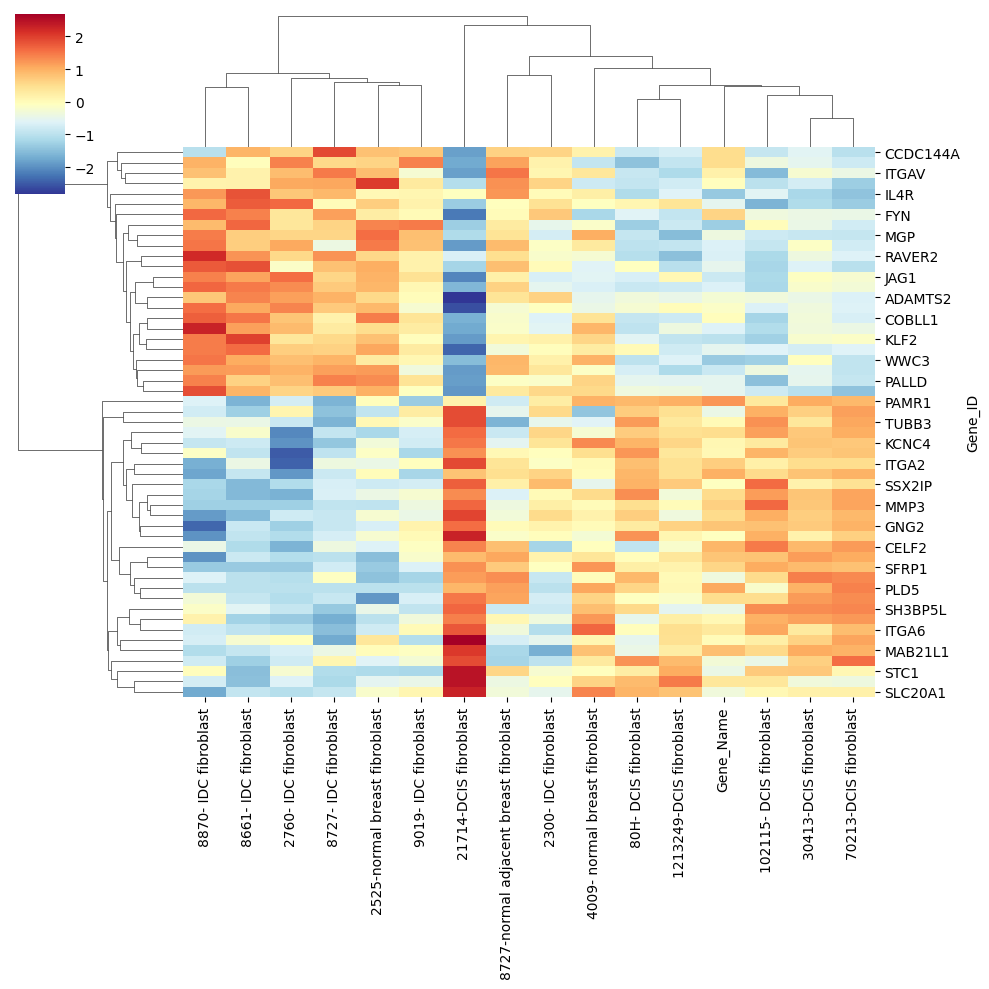

In [65]:
#This creates a hierarchical clustering heatmap of the log-transformed gene expression values for significant differentially expressed genes (DEGs).
#sns.clustermap(...) → Uses Seaborn’s clustermap function to generate a heatmap with hierarchical clustering.
#z_score=0 → Standardizes gene expression values row-wise (per gene):
#Each gene's expression is normalized to a mean of 0 and standard deviation of 1.
#Helps compare genes with different absolute expression levels.

g_cd =sns.clustermap(grapher_cd, z_score=0, cmap='RdYlBu_r')
g_cd

# Save the heatmap as an image file
g_cd.savefig("heatmap_cd.png", dpi=300)  # Save as PNG with high resolution

In [66]:
grapher_ci = pd.DataFrame(dds_sigs_ci.layers['log1p'].T, index= dds_sigs_ci.var_names, columns = dds_sigs_ci.obs_names)
grapher_ci

,Gene_Name,2525-normal breast fibroblast,8727-normal adjacent breast fibroblast,4009- normal breast fibroblast,30413-DCIS fibroblast,70213-DCIS fibroblast,80H- DCIS fibroblast,21714-DCIS fibroblast,1213249-DCIS fibroblast,102115- DCIS fibroblast,2760- IDC fibroblast,8727- IDC fibroblast,2300- IDC fibroblast,8870- IDC fibroblast,9019- IDC fibroblast,8661- IDC fibroblast
Gene_ID,,,,,,,,,,,,,,,,
ADAMTS2,5.357077,5.719589,5.653443,5.257944,5.280108,5.189434,5.328918,4.227907,5.269881,5.332317,5.991324,5.907779,5.762924,5.811737,5.468319,6.096094
ADAMTS7,3.620666,4.637470,3.533438,3.342792,3.414894,3.159217,3.520368,1.289986,3.752492,3.139576,5.091645,4.455411,3.681740,5.269598,3.539509,4.788576
C5orf30,2.781983,2.660033,2.426246,3.012397,3.138112,3.489759,3.371137,3.610397,3.230113,2.717354,2.586992,2.927526,2.512144,2.590820,2.790639,2.399738
CAMK2N1,2.407006,1.403270,2.426246,3.525922,3.448851,3.520554,1.890446,3.743514,2.575757,3.314655,1.061509,0.744356,2.029457,2.510600,2.039920,1.171470
CCDC144A,2.842644,3.157094,2.962182,2.515612,1.832973,1.404943,1.557768,0.629983,1.674507,1.511837,2.942433,4.175846,2.941345,1.407365,3.092210,3.281190
CELF2,3.145078,1.627535,3.074204,2.192985,3.138112,3.391239,1.337934,3.586380,2.071644,3.663608,0.665449,1.875706,1.060757,1.815144,2.157063,1.171470
COBLL1,3.859953,4.826409,3.770726,4.151952,3.685577,3.425169,3.304594,2.821165,3.358688,3.100557,4.387146,3.989800,3.470761,4.997618,4.145060,4.868691
DSTN,5.981253,6.516291,6.202315,6.720268,6.122190,6.081515,5.832323,5.464641,6.105891,5.765676,6.699651,6.413298,6.011228,7.361002,6.403666,6.823859
ESM1,2.953931,3.240553,2.319449,3.012397,3.481692,3.874415,2.505088,5.226655,3.328060,3.139576,2.891291,1.462156,2.512144,2.327817,2.039920,2.739145


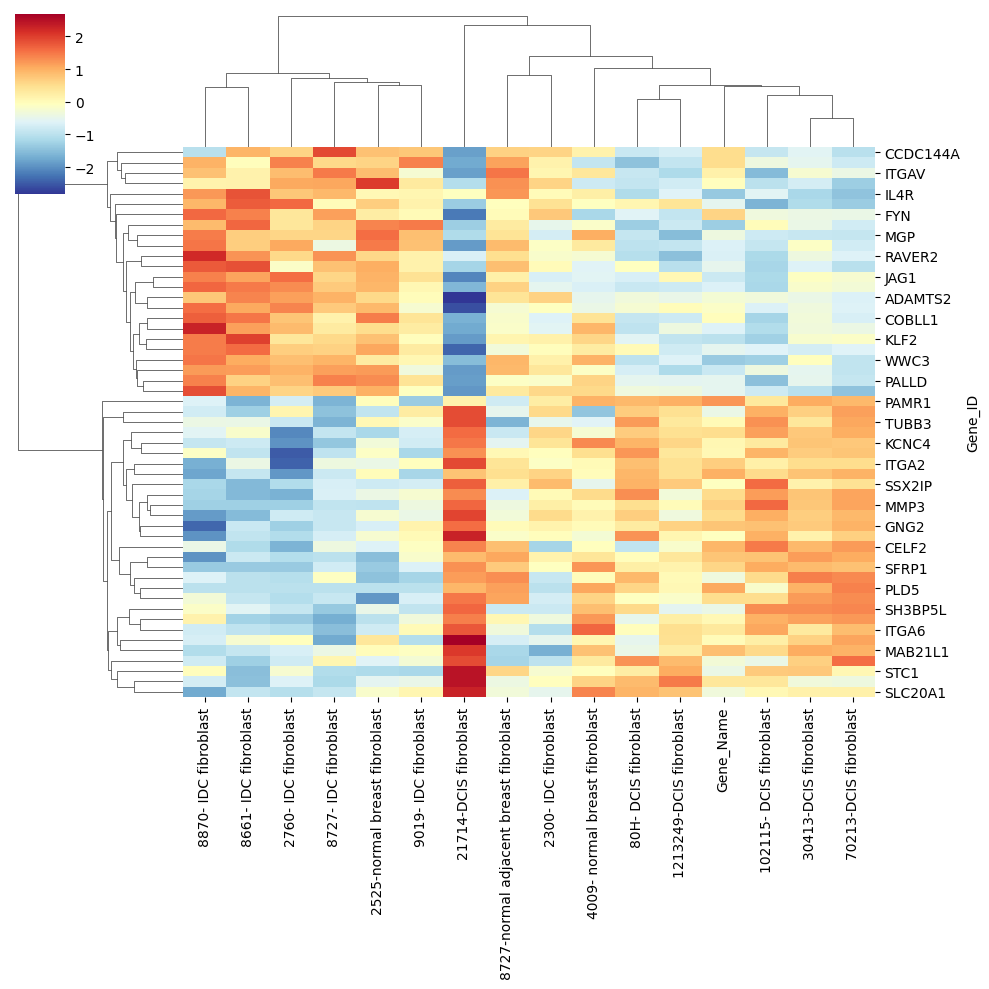

In [67]:
g_ci=sns.clustermap(grapher_ci, z_score=0, cmap='RdYlBu_r')
g_ci
g_ci.savefig("heatmap_ci.png", dpi=300)  # Save as PNG with high resolution

In [68]:
grapher_di = pd.DataFrame(dds_sigs_di.layers['log1p'].T, index= dds_sigs_di.var_names, columns = dds_sigs_di.obs_names)
grapher_di

,Gene_Name,2525-normal breast fibroblast,8727-normal adjacent breast fibroblast,4009- normal breast fibroblast,30413-DCIS fibroblast,70213-DCIS fibroblast,80H- DCIS fibroblast,21714-DCIS fibroblast,1213249-DCIS fibroblast,102115- DCIS fibroblast,2760- IDC fibroblast,8727- IDC fibroblast,2300- IDC fibroblast,8870- IDC fibroblast,9019- IDC fibroblast,8661- IDC fibroblast
Gene_ID,,,,,,,,,,,,,,,,
AURKB,1.800114,2.217312,1.490378,1.186267,2.347024,2.913799,3.269586,3.510662,3.082533,3.248255,2.991086,1.690158,3.163900,1.969955,2.356802,2.174020
CBX3,4.353693,4.353010,4.293390,4.115504,4.379357,4.535379,4.645120,4.819160,4.849025,4.744979,4.549563,4.347058,4.606662,4.371443,4.386072,4.488141
CCDC144A,2.842644,3.157094,2.962182,2.515612,1.832973,1.404943,1.557768,0.629983,1.674507,1.511837,2.942433,4.175846,2.941345,1.407365,3.092210,3.281190
CDC25B,3.698647,3.710892,3.309226,3.491881,3.711585,4.135261,4.125657,4.325379,4.034292,4.332309,3.987880,3.708266,4.192004,3.610748,3.762395,3.842630
CDCA5,1.800114,2.217312,1.490378,1.484385,2.241126,2.856560,3.304594,3.484092,3.121519,3.100557,2.942433,1.462156,2.989995,2.222149,2.157063,2.399738
CDKN1A,6.612591,6.337888,6.474872,6.637349,6.122190,5.970145,5.875333,5.733439,5.803373,5.850578,5.952770,6.479883,6.015847,6.006812,6.594640,6.118405
CKAP2L,1.800114,2.729132,2.064017,1.186267,2.530150,3.159217,3.600267,3.722523,3.598860,3.517475,3.379665,2.032154,3.499699,2.103981,2.665838,2.399738
CLSPN,1.800114,2.099219,1.191652,0.759598,2.122672,2.324922,3.073395,3.206585,3.263839,3.100557,3.165000,1.462156,2.836311,2.327817,2.261912,2.664474
DEK,4.553206,4.617465,4.411395,4.285754,4.653946,4.929882,5.016806,5.106595,5.067874,5.319421,5.037920,4.468165,5.107789,4.864059,4.708693,4.721500


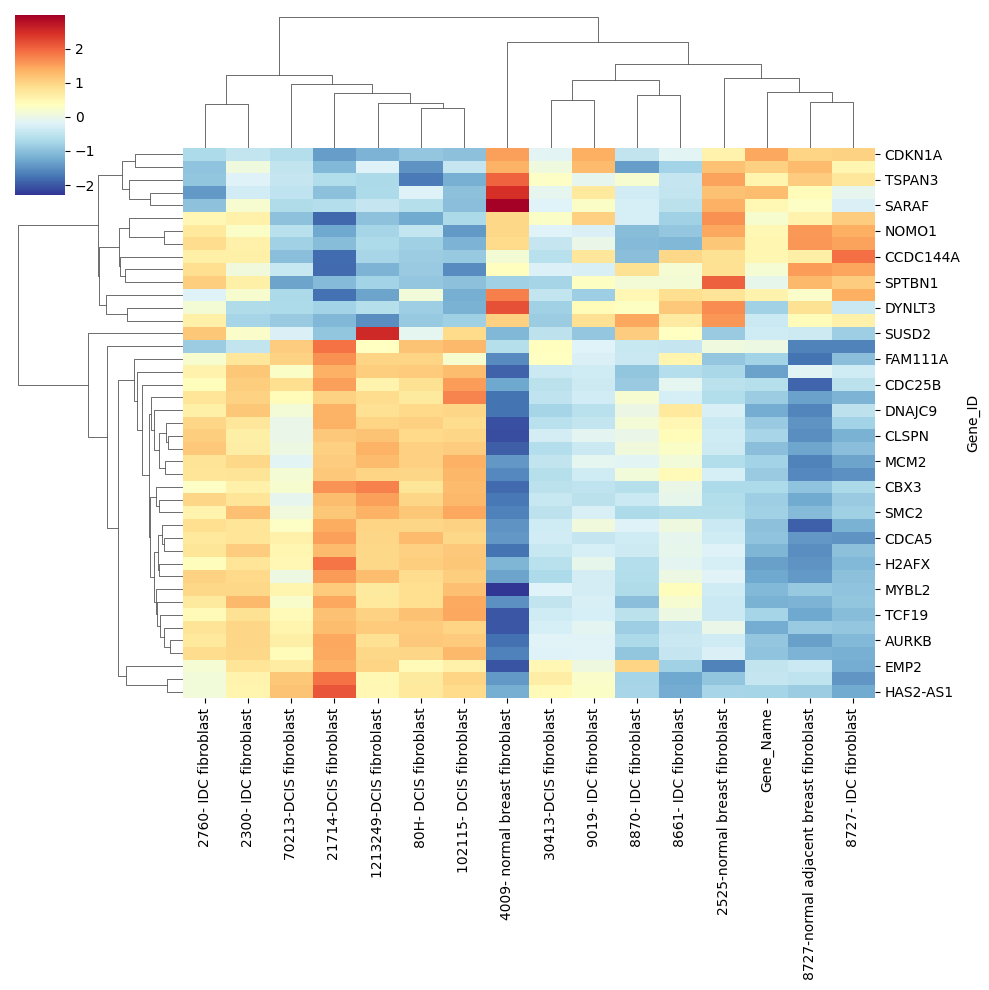

In [69]:
g_di= sns.clustermap(grapher_di, z_score=0, cmap='RdYlBu_r')
g_di
g_di.savefig("heatmap_di.png", dpi=300)  # Save as PNG with high resolution

In [70]:
import plotly.express as px
import pandas as pd
import numpy as np

# Define threshold values
log2fc_threshold = 0.5  # Minimum fold-change threshold
pval_threshold = 0.05   # Significance threshold

# Prepare data
results_cd['-log10(padj)'] = -np.log10(results_cd['padj'])  # Convert p-value scale
results_cd['Significance'] = np.where(
    (results_cd['padj'] < pval_threshold) & (results_cd['log2FoldChange'] > log2fc_threshold), 'Upregulated',
    np.where((results_cd['padj'] < pval_threshold) & (results_cd['log2FoldChange'] < -log2fc_threshold), 'Downregulated',
             'Not Significant')
)

# Create interactive volcano plot
fig = px.scatter(results_cd,
                 x="log2FoldChange",
                 y="-log10(padj)",
                 color="Significance",
                 hover_name=results_cd.index,  # Gene names
                 title="Volcano Plot of Differentially Expressed Genes",
                 labels={"log2FoldChange": "Log2 Fold Change", "-log10(padj)": "-Log10 Adjusted P-Value"},
                 color_discrete_map={"Upregulated": "red", "Downregulated": "blue", "Not Significant": "grey"}
                )

# Add significance threshold lines
fig.add_hline(y=-np.log10(pval_threshold), line_dash="dash", line_color="black")
fig.add_vline(x=log2fc_threshold, line_dash="dash", line_color="black")
fig.add_vline(x=-log2fc_threshold, line_dash="dash", line_color="black")

# **Adjust figure size**
fig.update_layout(
    autosize=True,
    width=1000,  # Width can be adjusted as needed
    height=800,  # Increased height for better visibility
    font=dict(size=14)  # Adjust font size for readability
)

# Show interactive plot
fig.show()

<ipython-input-70-6fd029e4e5fa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cd['-log10(padj)'] = -np.log10(results_cd['padj'])  # Convert p-value scale
<ipython-input-70-6fd029e4e5fa>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_cd['Significance'] = np.where(


In [71]:
import plotly.express as px
import pandas as pd
import numpy as np

# Define threshold values
log2fc_threshold = 0.5  # Minimum fold-change threshold
pval_threshold = 0.05   # Significance threshold

# Prepare data
results_ci['-log10(padj)'] = -np.log10(results_ci['padj'])  # Convert p-value scale
results_ci['Significance'] = np.where(
    (results_ci['padj'] < pval_threshold) & (results_ci['log2FoldChange'] > log2fc_threshold), 'Upregulated',
    np.where((results_ci['padj'] < pval_threshold) & (results_ci['log2FoldChange'] < -log2fc_threshold), 'Downregulated',
             'Not Significant')
)

# Create interactive volcano plot
fig = px.scatter(results_ci,
                 x="log2FoldChange",
                 y="-log10(padj)",
                 color="Significance",
                 hover_name=results_cd.index,  # Gene names
                 title="Volcano Plot of Differentially Expressed Genes",
                 labels={"log2FoldChange": "Log2 Fold Change", "-log10(padj)": "-Log10 Adjusted P-Value"},
                 color_discrete_map={"Upregulated": "red", "Downregulated": "blue", "Not Significant": "grey"}
                )

# Add significance threshold lines
fig.add_hline(y=-np.log10(pval_threshold), line_dash="dash", line_color="black")
fig.add_vline(x=log2fc_threshold, line_dash="dash", line_color="black")
fig.add_vline(x=-log2fc_threshold, line_dash="dash", line_color="black")

# **Adjust figure size**
fig.update_layout(
    autosize=True,
    width=1000,  # Width can be adjusted as needed
    height=800,  # Increased height for better visibility
    font=dict(size=14)  # Adjust font size for readability
)

# Show interactive plot
fig.show()

<ipython-input-71-375d5885f0da>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-71-375d5885f0da>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [72]:
import plotly.express as px
import pandas as pd
import numpy as np

# Define threshold values
log2fc_threshold = 0.5  # Minimum fold-change threshold
pval_threshold = 0.05   # Significance threshold

# Prepare data
results_di['-log10(padj)'] = -np.log10(results_di['padj'])  # Convert p-value scale
results_di['Significance'] = np.where(
    (results_di['padj'] < pval_threshold) & (results_di['log2FoldChange'] > log2fc_threshold), 'Upregulated',
    np.where((results_di['padj'] < pval_threshold) & (results_di['log2FoldChange'] < -log2fc_threshold), 'Downregulated',
             'Not Significant')
)

# Create interactive volcano plot
fig = px.scatter(results_di,
                 x="log2FoldChange",
                 y="-log10(padj)",
                 color="Significance",
                 hover_name=results_cd.index,  # Gene names
                 title="Volcano Plot of Differentially Expressed Genes",
                 labels={"log2FoldChange": "Log2 Fold Change", "-log10(padj)": "-Log10 Adjusted P-Value"},
                 color_discrete_map={"Upregulated": "red", "Downregulated": "blue", "Not Significant": "grey"}
                )

# Add significance threshold lines
fig.add_hline(y=-np.log10(pval_threshold), line_dash="dash", line_color="black")
fig.add_vline(x=log2fc_threshold, line_dash="dash", line_color="black")
fig.add_vline(x=-log2fc_threshold, line_dash="dash", line_color="black")

# **Adjust figure size**
fig.update_layout(
    autosize=True,
    width=1000,  # Width can be adjusted as needed
    height=800,  # Increased height for better visibility
    font=dict(size=14)  # Adjust font size for readability
)

# Show interactive plot
fig.show()

<ipython-input-72-adf07021bf9c>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-72-adf07021bf9c>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape data for plotting
norm_counts_melted = norm_counts_df.melt(ignore_index=False, var_name="Sample", value_name="Normalized Expression")

# Ensure metadata index matches 'Sample'
if "level_0" in metadata.columns:  # Prevent duplicate level_0 column
    metadata = metadata.drop(columns=["level_0"])

metadata = metadata.reset_index(drop=True)  # Drop existing index safely

print("Metadata Columns:", metadata.columns)  # Debugging step

# Merge with metadata to get 'Condition'
norm_counts_melted = norm_counts_melted.merge(metadata[["Sample", "Condition"]], on="Sample", how="left")

# Check for issues
print("\nMissing Values:\n", norm_counts_melted.isna().sum())
print("\nUnique Conditions:\n", norm_counts_melted["Condition"].unique())
print("\nExpression Stats:\n", norm_counts_melted["Normalized Expression"].describe())

# Drop NaN values if any
norm_counts_melted = norm_counts_melted.dropna()

# Generate Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x="Condition", y="Normalized Expression", data=norm_counts_melted, palette="Set2")

# Customize plot
plt.title("Violin Plot of Normalized Gene Expression")
plt.xlabel("Condition")
plt.ylabel("Normalized Expression")
plt.xticks(rotation=45)

# Show plot
plt.show()
#The width of each violin represents the density of data points at different expression levels.
#All three distributions appear similar in shape and spread, meaning the expression distributions across the conditions are not drastically different.
#The white horizontal line inside each violin represents the median expression.
#The box plot inside the violin shows the interquartile range (middle 50% of the data).
#The expression medians are close across all conditions, suggesting no major shift in gene expression.
#the longer tails in all three conditions indicate some samples have much higher/lower expression values.
#The tails are slightly asymmetric, meaning the distribution is not perfectly normal.


NameError: name 'norm_counts_df' is not defined